In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

In [9]:
# Define the paths to your dataset
train_dir = '/home/alienblade/College Stuff/Workspace/AI/Master Folder/train'
validation_dir = '/home/alienblade/College Stuff/Workspace/AI/Master Folder/valid'
test_dir = '/home/alienblade/College Stuff/Workspace/AI/Master Folder/test'
# Define image dimensions
img_height = 150
img_width = 150
batch_size = 32

In [10]:
# Use ImageDataGenerator for data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
# Load and preprocess the dataset
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_data = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1000 images belonging to 4 classes.
Found 36 images belonging to 4 classes.
Found 38 images belonging to 4 classes.


In [12]:
# Load the pre-trained VGG16 model without the top layer
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the pre-trained layers
for layer in base_model_vgg16.layers[:-2]:
    layer.trainable = False


# Add your custom top layer for classification
x = GlobalAveragePooling2D()(base_model_vgg16.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization
x = Dense(128, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

# Create the model
model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=predictions)

In [13]:
# Compile the model
model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
history_vgg16 = model_vgg16.fit(
    train_data,
    steps_per_epoch=train_data.samples // batch_size,
    epochs=20,
    validation_data=validation_data,
    validation_steps=validation_data.samples // batch_size
)

Epoch 1/20
31/31 [==============================] - 42s 1s/step - loss: 1.5401 - accuracy: 0.2510 - val_loss: 1.4009 - val_accuracy: 0.2500
Epoch 2/20
31/31 [==============================] - 41s 1s/step - loss: 1.3848 - accuracy: 0.2727 - val_loss: 1.3267 - val_accuracy: 0.2500
Epoch 3/20
31/31 [==============================] - 42s 1s/step - loss: 1.3146 - accuracy: 0.3771 - val_loss: 1.2807 - val_accuracy: 0.3438
Epoch 4/20
31/31 [==============================] - 45s 1s/step - loss: 1.2371 - accuracy: 0.4244 - val_loss: 1.2122 - val_accuracy: 0.4062
Epoch 5/20
31/31 [==============================] - 41s 1s/step - loss: 1.1715 - accuracy: 0.4669 - val_loss: 1.3785 - val_accuracy: 0.5000
Epoch 6/20
31/31 [==============================] - 43s 1s/step - loss: 1.0995 - accuracy: 0.5083 - val_loss: 1.5603 - val_accuracy: 0.4062
Epoch 7/20
31/31 [==============================] - 44s 1s/step - loss: 1.0558 - accuracy: 0.5413 - val_loss: 1.5628 - val_accuracy: 0.3438
Epoch 8/20
31/31 [==

In [15]:
# Evaluate the model
test_loss, test_acc = model_vgg16.evaluate(test_data)
print('Test accuracy:', test_acc)

# Save the model
model_vgg16.save('pec_vgg.h5')

2/2 [==============================] - 2s 270ms/step - loss: 4.8571 - accuracy: 0.3421
Test accuracy: 0.34210526943206787


/home/alienblade/College Stuff/Workspace/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Graphs

Found 38 images belonging to 4 classes.
2/2 [==============================] - 2s 265ms/step


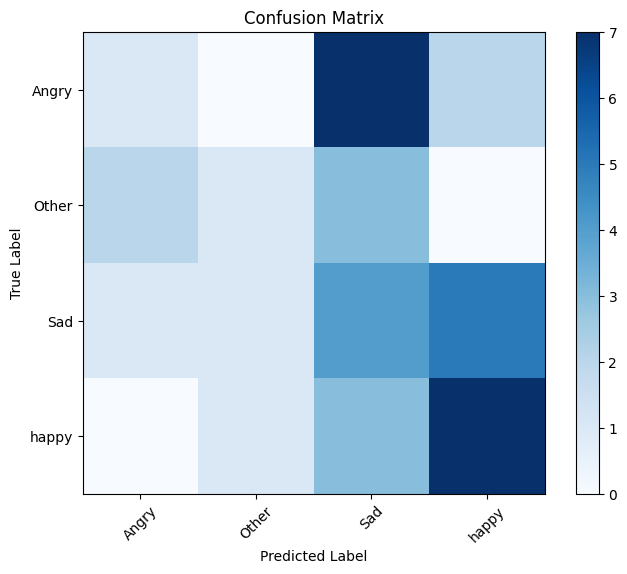

In [16]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Load the saved model
model = load_model('pec_vgg.h5')

# Use ImageDataGenerator for data preprocessing (no augmentation for test data)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess the test dataset
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Keep data in the same order as labels
)

# Make predictions on the test dataset
y_pred = model.predict(test_data)
y_pred_labels = np.argmax(y_pred, axis=1)

# Get the true labels from the test dataset
true_labels = test_data.classes

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_data.class_indices))
plt.xticks(tick_marks, test_data.class_indices, rotation=45)
plt.yticks(tick_marks, test_data.class_indices)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


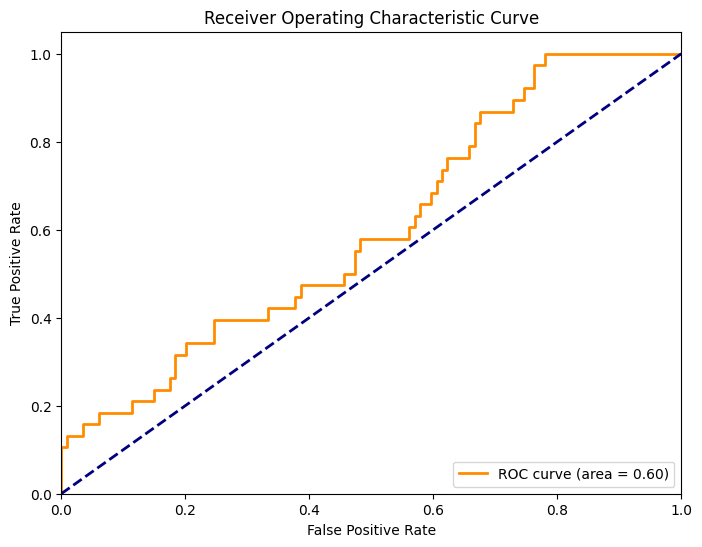

Found 38 images belonging to 4 classes.
2/2 [==============================] - 2s 256ms/step


NameError: name 'interp1d' is not defined

In [17]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc

# Convert multiclass labels to binary labels
lb = LabelBinarizer()
true_labels_bin = lb.fit_transform(true_labels)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(true_labels_bin.ravel(), y_pred.ravel())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()
# Load the saved model
model = load_model('pec_vgg.h5')

# Use ImageDataGenerator for data preprocessing (no augmentation for test data)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess the test dataset
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Keep data in the same order as labels
)

# Make predictions on the test dataset
y_pred = model.predict(test_data)

# Get the true labels from the test dataset
true_labels = test_data.classes

# Calculate ROC curve
fpr, tpr, _ = roc_curve(true_labels_bin.ravel(), y_pred.ravel())
roc_auc = auc(fpr, tpr)

# Interpolate the ROC curve for smoother plotting
fpr_interp = np.linspace(0, 1, 100)
tpr_interp = interp1d(fpr, tpr)(fpr_interp)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_interp, tpr_interp, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()


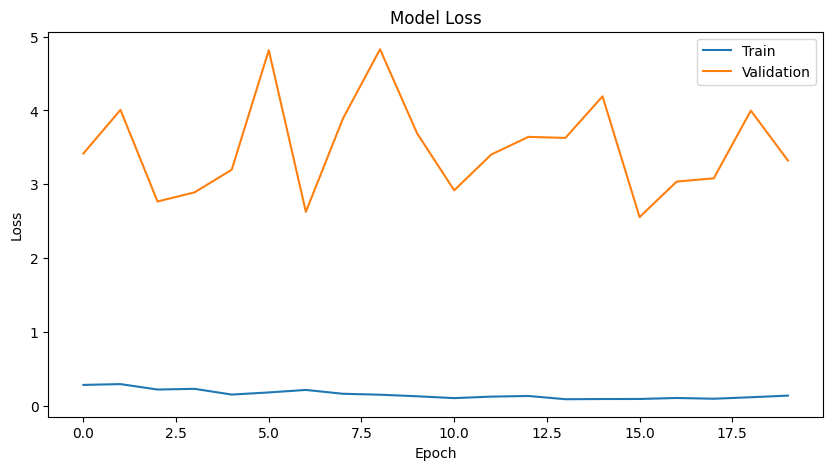

In [ ]:

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history_vgg16.history['loss'])
plt.plot(history_vgg16.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

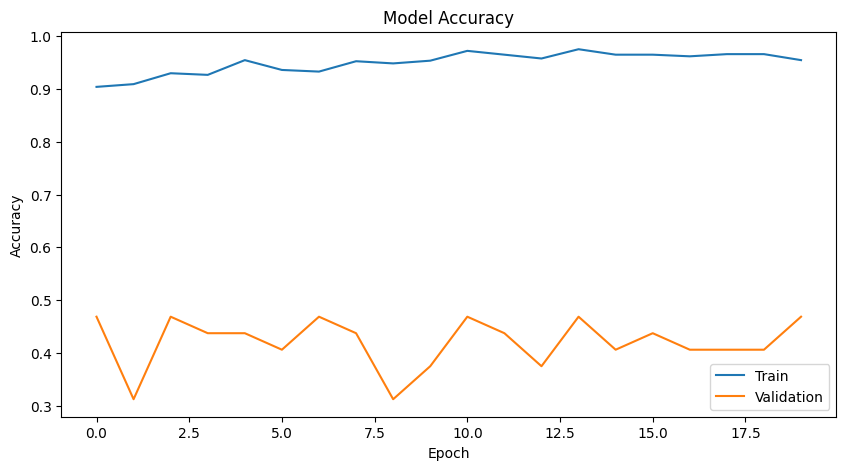

In [ ]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()
